# Capstone 20.1 — Initial Report, EDA, and Baseline Model (Stocks)

**Research question:** Can daily log returns for selected large-cap U.S. equities be treated as approximately stationary, and can simple baseline models outperform a naive forecast for short-horizon return prediction?

**Tickers:** AAPL, MSFT, JPM, XOM (stocks) + SPY (market proxy)  
**Date range:** 2015-01-01 to 2024-12-31  
**Primary target:** daily log return of each stock


## 1) Where the data comes from (and how to get it)

### Option A (recommended): Yahoo Finance via `yfinance`
- Data fields: Date, Open/High/Low/Close/Adj Close, Volume
- We will use **Adjusted Close** and **Volume**

Install (once):
```bash
pip install yfinance
```

### Option B (fallback): Stooq via `pandas-datareader`
- Often works without authentication; data availability varies by ticker
- Install (once):
```bash
pip install pandas-datareader
```


In [1]:
# If you're running this in a fresh environment, uncomment:
# !pip -q install yfinance statsmodels scikit-learn

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

plt.rcParams["figure.figsize"] = (10, 4)


## 2) Load data

In [2]:
import yfinance as yf

TICKERS = ["AAPL", "MSFT", "JPM", "XOM", "SPY"]
START = "2015-01-01"
END = "2024-12-31"

raw = yf.download(TICKERS, start=START, end=END, auto_adjust=False, progress=False)

# We use Adjusted Close and Volume
adj = raw["Adj Close"].copy()
vol = raw["Volume"].copy()

adj.head()

Ticker,AAPL,JPM,MSFT,SPY,XOM
Date,,,,,
2015-01-02,24.214891,46.511124,39.858448,170.589615,57.533443
2015-01-05,23.532724,45.067196,39.491932,167.508789,55.959183
2015-01-06,23.534929,43.898651,38.912292,165.931061,55.661705
2015-01-07,23.864946,43.965633,39.406677,167.998779,56.225716
2015-01-08,24.781891,44.948101,40.565964,170.979874,57.161568


## 3) Basic data checks (missing values, duplicates, date range)

In [3]:
print("Adj Close shape:", adj.shape)
print("Volume shape:", vol.shape)
print("Date range:", adj.index.min().date(), "to", adj.index.max().date())

missing_adj = adj.isna().sum().sort_values(ascending=False)
missing_vol = vol.isna().sum().sort_values(ascending=False)

print("\nMissing Adjusted Close (top):")
print(missing_adj.head(10))

print("\nMissing Volume (top):")
print(missing_vol.head(10))

# Ensure monotonic index
adj = adj.sort_index()
vol = vol.sort_index()


Adj Close shape: (2515, 5)
Volume shape: (2515, 5)
Date range: 2015-01-02 to 2024-12-30

Missing Adjusted Close (top):
Ticker
AAPL    0
JPM     0
MSFT    0
SPY     0
XOM     0
dtype: int64

Missing Volume (top):
Ticker
AAPL    0
JPM     0
MSFT    0
SPY     0
XOM     0
dtype: int64


## 4) Feature engineering

We focus on **log returns** (more likely to be stationary than prices):

\[ r_t = \log(P_t) - \log(P_{t-1}) \]

We also engineer:
- lagged returns (1–5 days)
- rolling volatility (5-day and 20-day std of returns)
- log volume change
- SPY log return as market proxy


In [4]:
# Compute log returns for all tickers
log_prices = np.log(adj)
returns = log_prices.diff().rename(columns=lambda c: f"{c}_ret")

# Rolling vol for returns
roll5 = returns.rolling(5).std().rename(columns=lambda c: c.replace("_ret", "_vol5"))
roll20 = returns.rolling(20).std().rename(columns=lambda c: c.replace("_ret", "_vol20"))

# Log volume change
log_vol = np.log(vol.replace(0, np.nan))
vol_chg = log_vol.diff().rename(columns=lambda c: f"{c}_volchg")

# Combine into one frame
df = pd.concat([adj, returns, roll5, roll20, vol_chg], axis=1)

# Add SPY return as exogenous feature for all stocks
df["SPY_ret"] = returns["SPY_ret"]

# Drop rows with NaNs created by diff/rolling
df = df.dropna()

df.head()

Ticker,AAPL,JPM,MSFT,SPY,XOM,AAPL_ret,JPM_ret,MSFT_ret,SPY_ret,XOM_ret,...,AAPL_vol20,JPM_vol20,MSFT_vol20,SPY_vol20,XOM_vol20,AAPL_volchg,JPM_volchg,MSFT_volchg,SPY_volchg,XOM_volchg
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-02,26.274698,41.286175,35.187275,167.674911,55.519154,0.012469,0.019846,0.021548,0.012308,0.024408,...,0.023655,0.020019,0.028178,0.011045,0.015772,-0.288798,-0.282690,-0.437723,-0.192495,-0.110548
2015-02-03,26.279127,42.216537,35.460033,170.099625,57.173943,0.000169,0.022284,0.007722,0.014357,0.029370,...,0.022407,0.020017,0.028337,0.010748,0.015993,-0.189364,-0.076538,0.033779,-0.272409,0.075597
2015-02-04,26.480680,41.963486,35.664616,169.451950,56.684311,0.007640,-0.006012,0.005753,-0.003815,-0.008601,...,0.022374,0.019291,0.028351,0.010537,0.016079,0.301010,-0.230874,-0.224371,0.078129,-0.109357
2015-02-05,26.669676,42.253757,36.184597,171.162567,57.242111,0.007112,0.006893,0.014474,0.010044,0.009792,...,0.022298,0.019383,0.028412,0.010417,0.016070,-0.507117,-0.279384,-0.129824,-0.315636,-0.427023
2015-02-06,26.445103,43.087372,36.150505,170.689240,57.135975,-0.008456,0.019537,-0.000943,-0.002769,-0.001856,...,0.021155,0.019223,0.027336,0.009672,0.015650,0.033985,0.803137,-0.054299,0.249186,-0.038015


## 5) EDA — prices vs. returns

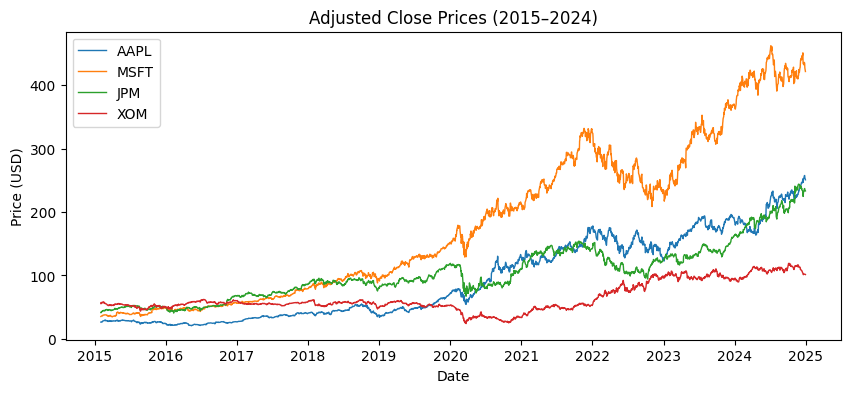

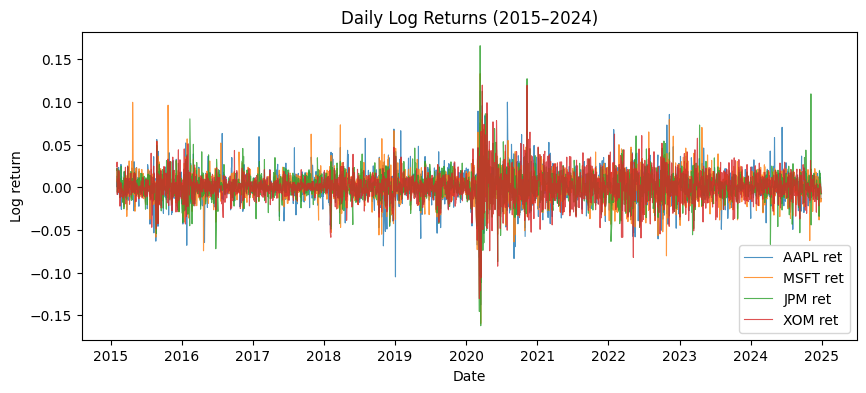

In [5]:
# Plot adjusted close prices
fig, ax = plt.subplots()
for t in ["AAPL", "MSFT", "JPM", "XOM"]:
    ax.plot(df.index, df[t], label=t, linewidth=1)
ax.set_title("Adjusted Close Prices (2015–2024)")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
plt.show()

# Plot returns
fig, ax = plt.subplots()
for t in ["AAPL", "MSFT", "JPM", "XOM"]:
    ax.plot(df.index, df[f"{t}_ret"], label=f"{t} ret", linewidth=0.8, alpha=0.8)
ax.set_title("Daily Log Returns (2015–2024)")
ax.set_xlabel("Date")
ax.set_ylabel("Log return")
ax.legend()
plt.show()


## 6) EDA — distributions and outliers

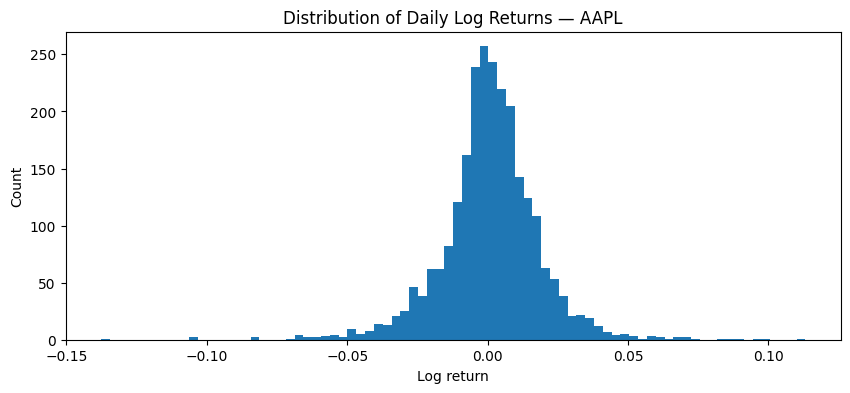

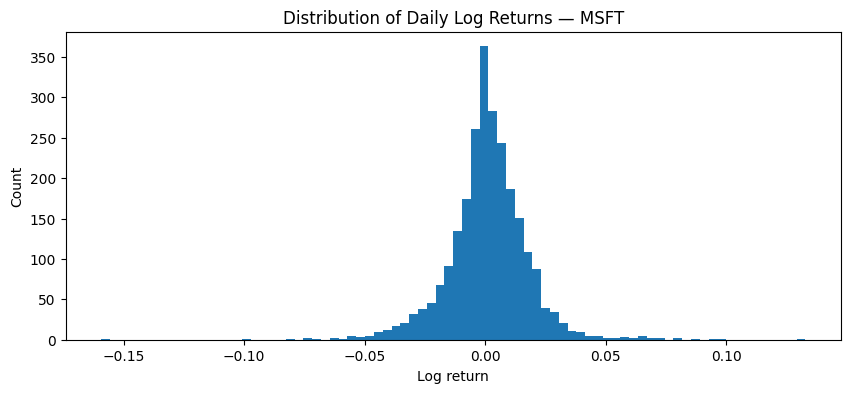

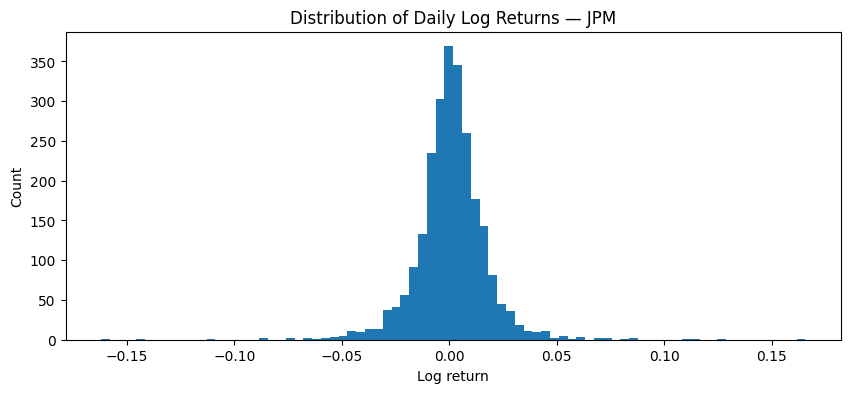

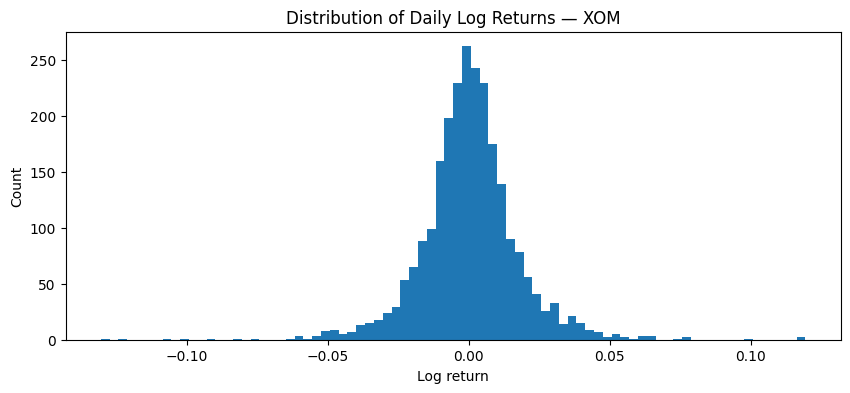

Ticker,AAPL_ret,ticker,z,MSFT_ret,JPM_ret,XOM_ret
Date,,,,,,
2020-03-13,NaN,JPM,9.599170,NaN,0.165620,NaN
2020-03-16,NaN,JPM,-9.476328,NaN,-0.162106,NaN
2020-03-16,NaN,MSFT,-9.455145,-0.159453,NaN,NaN
2020-03-09,NaN,JPM,-8.512821,NaN,-0.145552,NaN
2020-03-13,NaN,MSFT,7.773829,0.132929,NaN,NaN
2020-03-16,-0.137708,AAPL,-7.752908,NaN,NaN,NaN
2020-03-09,NaN,XOM,-7.455479,NaN,NaN,-0.130391
2020-11-09,NaN,JPM,7.349985,NaN,0.126978,NaN
2020-03-12,NaN,XOM,-6.943654,NaN,NaN,-0.121422


In [6]:
stocks = ["AAPL", "MSFT", "JPM", "XOM"]

# Histograms of returns
for t in stocks:
    fig, ax = plt.subplots()
    ax.hist(df[f"{t}_ret"], bins=80)
    ax.set_title(f"Distribution of Daily Log Returns — {t}")
    ax.set_xlabel("Log return")
    ax.set_ylabel("Count")
    plt.show()

# Simple outlier identification: |z| > 3
outliers = []
for t in stocks:
    r = df[f"{t}_ret"]
    z = (r - r.mean()) / r.std(ddof=0)
    out = df.loc[z.abs() > 3, [f"{t}_ret"]].copy()
    out["ticker"] = t
    out["z"] = z.loc[z.abs() > 3]
    outliers.append(out)

outliers_df = pd.concat(outliers).sort_values("z", key=lambda s: s.abs(), ascending=False)
outliers_df.head(10)

## 7) EDA — volatility clustering (rolling volatility)

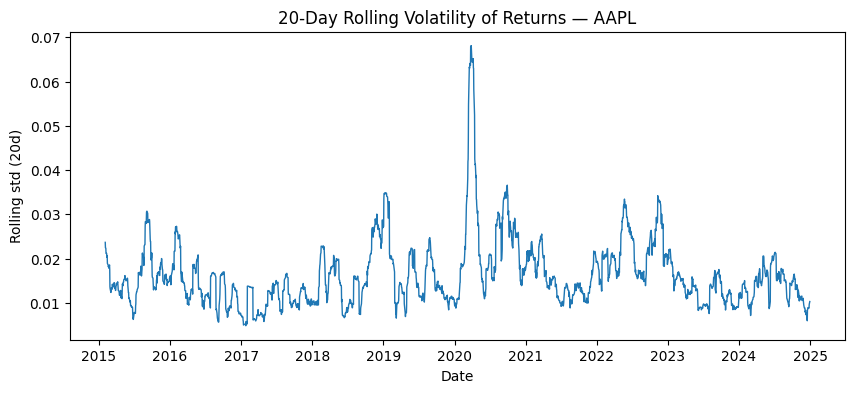

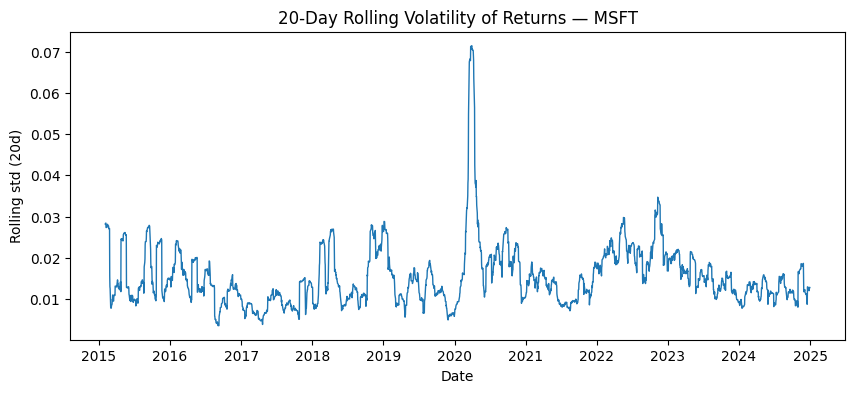

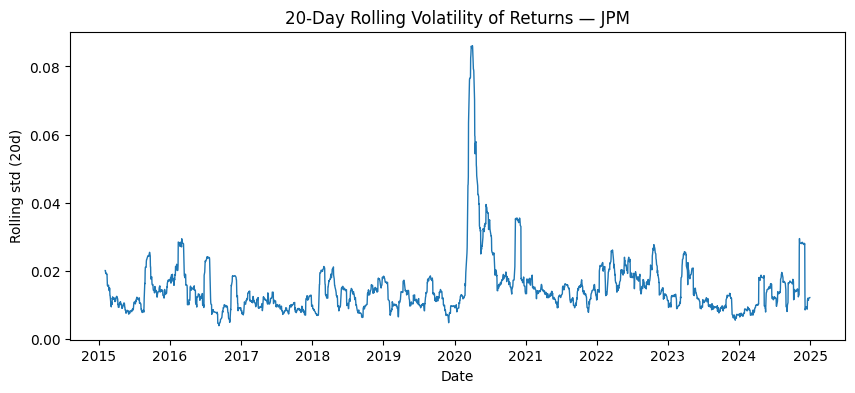

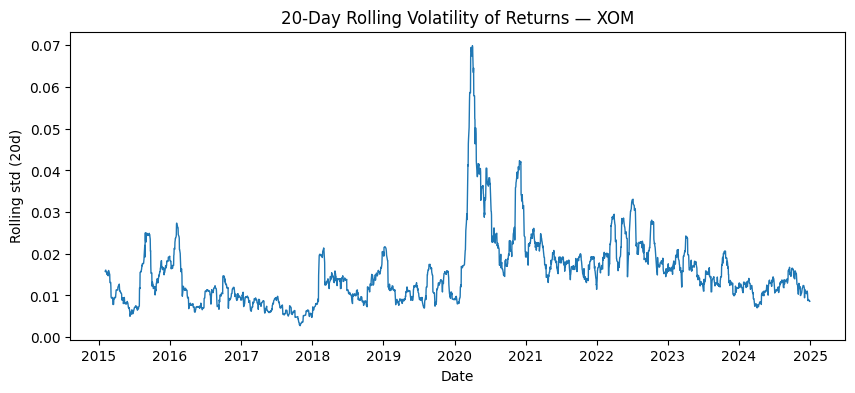

In [7]:
for t in stocks:
    fig, ax = plt.subplots()
    ax.plot(df.index, df[f"{t}_vol20"], linewidth=1)
    ax.set_title(f"20-Day Rolling Volatility of Returns — {t}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Rolling std (20d)")
    plt.show()


## 8) EDA — autocorrelation (ACF) for returns

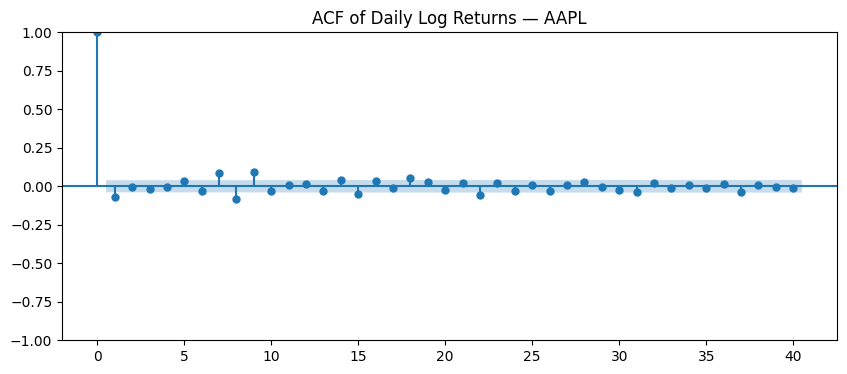

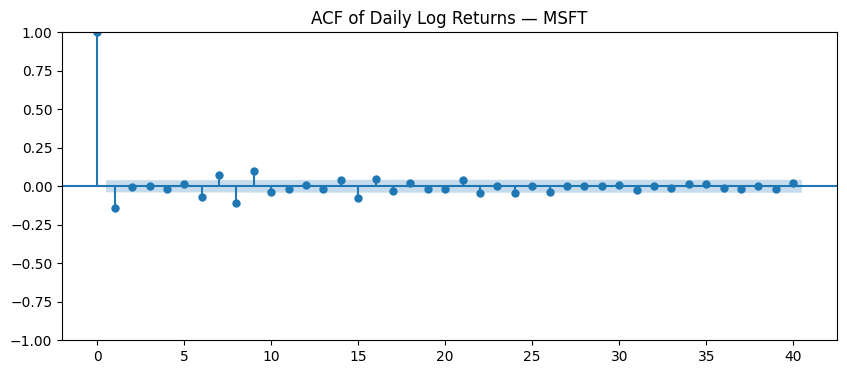

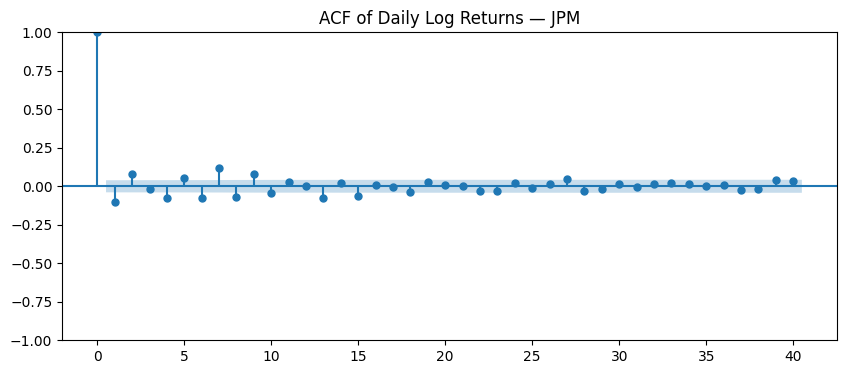

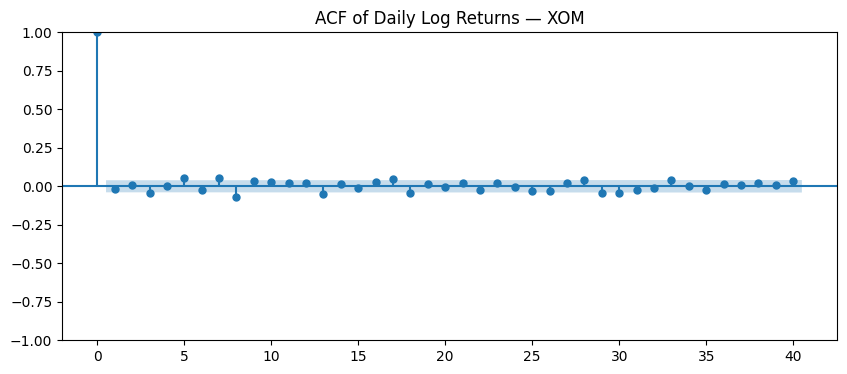

In [8]:
# ACF plots for returns (stationarity check / temporal dependence)
for t in stocks:
    sm.graphics.tsa.plot_acf(df[f"{t}_ret"], lags=40)
    plt.title(f"ACF of Daily Log Returns — {t}")
    plt.show()


## 9) EDA — correlation (engineered features)

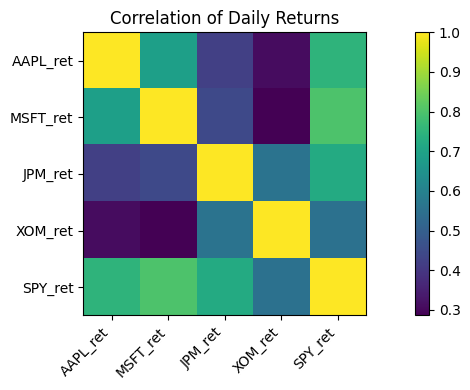

In [9]:
# Correlation of returns across assets + SPY
corr = df[[f"{t}_ret" for t in stocks] + ["SPY_ret"]].corr()

fig, ax = plt.subplots()
im = ax.imshow(corr.values)
ax.set_xticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticks(range(len(corr.index)))
ax.set_yticklabels(corr.index)
ax.set_title("Correlation of Daily Returns")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


## 10) Baseline modeling (required)

We build a baseline model to predict **next-day return** for one target stock (AAPL by default).

Models:
1. **Naive baseline:** predict 0 return for all days  
2. **Ridge regression baseline:** use lagged returns + volatility + volume change + SPY return

Evaluation:
- **time-based** train/test split (last 20% of dates held out)
- metric: **RMSE** (and MSE) on returns


In [10]:
TARGET = "AAPL"

# Build supervised dataset for next-day prediction
data = df.copy()

# target: next day's return
data["y"] = data[f"{TARGET}_ret"].shift(-1)

# predictors: lagged returns of target + SPY, volatility, volume change
for k in range(1, 6):
    data[f"{TARGET}_ret_lag{k}"] = data[f"{TARGET}_ret"].shift(k)
    data[f"SPY_ret_lag{k}"] = data["SPY_ret"].shift(k)

feature_cols = (
    [f"{TARGET}_ret_lag{k}" for k in range(1, 6)] +
    [f"SPY_ret_lag{k}" for k in range(1, 6)] +
    [f"{TARGET}_vol5", f"{TARGET}_vol20", f"{TARGET}_volchg", "SPY_ret"]
)

model_df = data[feature_cols + ["y"]].dropna()

X = model_df[feature_cols]
y = model_df["y"]

# Time-based split: last 20% as test
split_idx = int(len(model_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (1991, 14) Test size: (498, 14)


In [11]:
# Baseline 1: naive predict 0
y_pred_naive = np.zeros_like(y_test.values)
mse_naive = mean_squared_error(y_test, y_pred_naive)
rmse_naive = np.sqrt(mse_naive)

# Baseline 2: Ridge regression (standardized)
ridge_model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0, random_state=42))
])

ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

print(f"Naive baseline:   MSE={mse_naive:.6f}  RMSE={rmse_naive:.6f}")
print(f"Ridge baseline:   MSE={mse_ridge:.6f}  RMSE={rmse_ridge:.6f}")


Naive baseline:   MSE=0.000182  RMSE=0.013495
Ridge baseline:   MSE=0.000189  RMSE=0.013737


### Visual: actual vs predicted returns (test period)

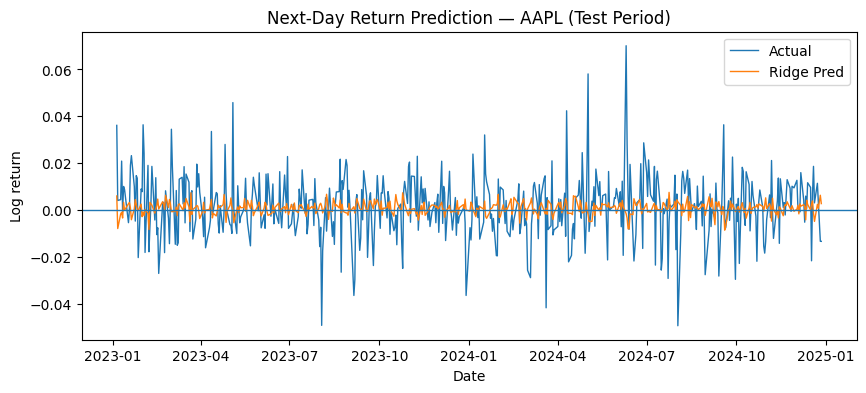

In [12]:
fig, ax = plt.subplots()
ax.plot(y_test.index, y_test.values, label="Actual", linewidth=1)
ax.plot(y_test.index, y_pred_ridge, label="Ridge Pred", linewidth=1)
ax.axhline(0, linewidth=1)
ax.set_title(f"Next-Day Return Prediction — {TARGET} (Test Period)")
ax.set_xlabel("Date")
ax.set_ylabel("Log return")
ax.legend()
plt.show()


## 11) Interpretability: which features mattered?

In [13]:
# For Ridge, interpretability comes from coefficients (after scaling).
coef = ridge_model.named_steps["ridge"].coef_
coef_s = pd.Series(coef, index=feature_cols).sort_values(key=lambda s: s.abs(), ascending=False)

coef_s.head(15)

SPY_ret         -0.002447
SPY_ret_lag5    -0.002168
AAPL_vol5       -0.001848
AAPL_ret_lag2   -0.001417
SPY_ret_lag2     0.001316
AAPL_ret_lag1   -0.001181
SPY_ret_lag1     0.001151
SPY_ret_lag3    -0.001040
AAPL_ret_lag5    0.000987
AAPL_vol20       0.000959
AAPL_ret_lag4    0.000693
AAPL_ret_lag3    0.000487
SPY_ret_lag4    -0.000475
AAPL_volchg     -0.000393
dtype: float64

## 12) Summary and next steps

**What we learned from EDA (expected):**
- Prices are typically non-stationary; returns are closer to stationary.
- Returns show heavy tails and volatility clustering.
- Correlations with SPY help explain market-driven movement.

**Baseline outcome (expected):**
- A naive baseline (0 return) can be hard to beat.
- Simple regression on lagged returns + volatility + SPY may provide modest gains.

**Next steps (Module 24):**
- Walk-forward validation (rolling window evaluation)
- Compare AR/MA/ARMA models on returns
- Add additional features (e.g., VIX as volatility proxy) and robust metrics
- Consider predicting direction as a classification task (optional secondary analysis)
